## Import the requisite modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import random
import numpy as np

## Get the data loader objects

In [2]:
torch.manual_seed(1)
batch_size = 64
use_cuda = torch.cuda.is_available()

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
train_data = []
for data, targ in train_loader.dataset:
   rand_num = random.randint(0,9)
   data = (data,F.one_hot(torch.tensor(rand_num),10))
   targ = (targ,targ+rand_num)
   train_data.append([data, targ])

In [4]:
train_loader_mod = torch.utils.data.DataLoader(train_data,batch_size=64)

In [5]:
test_data = []
for data, targ in test_loader.dataset:
   rand_num = random.randint(0,9)
   data = (data,F.one_hot(torch.tensor(rand_num),10))
   targ = (targ,targ+rand_num)
   test_data.append([data, targ])

In [6]:
test_loader_mod = torch.utils.data.DataLoader(test_data,batch_size=1024)

## The Network

In [7]:
class AdditionNet(nn.Module):
    def __init__(self):
        super(AdditionNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(20,32)
        self.fc4 = nn.Linear(32,64)
        self.fc5 = nn.Linear(64,32)
        self.fc6 = nn.Linear(32,19)

    def forward(self, x, num):
    # def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        x1 = F.one_hot(x.argmax(-1), 10)

        # num = torch.zeros(2,10)

        # print(x1.shape, num.shape)
        y = torch.cat((x1.squeeze(0),num),-1).float()

        y = F.relu(self.fc3(y))
        y = F.relu(self.fc4(y))
        y = F.relu(self.fc5(y))
        y = self.fc6(y)

        return F.log_softmax(x), F.log_softmax(y)

## Print Model Summary

In [8]:
# !pip install torchsummary
# from torchsummary import summary
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# model = AdditionNet().to(device)
# summary(model, input_size=(1, 28, 28))

## Define the optimizer

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = AdditionNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Define Train and Test functions

In [10]:
losses = []
accuracies = []

from tqdm import tqdm
def train(model, device, train_loader_mod, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader_mod)
    total_loss_summed = 0
    cntr = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # data, target = data.to(device), target.to(device)
        image, num = data
        label, summation = target
        image, num, label, summation = image.to(device), num.to(device), label.to(device), summation.to(device)

        optimizer.zero_grad()

        pred_label, pred_sum = model(image, num)

        if epoch < 3:
          loss_1 = F.nll_loss(pred_label, label.long())
          loss_1.backward()
          loss = loss_1
        else:
          loss_2 = F.nll_loss(pred_sum, summation.long())
          loss_2.backward()
          loss = loss_2

        losses.append(loss.item())
        total_loss_summed += loss.item()
        cntr += 1
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    return total_loss_summed / cntr


def test(model, device, test_loader_mod):
    model.eval()
    loss_1 = 0
    loss_2 = 0
    correct_digit = 0
    correct_sum = 0

    with torch.no_grad():
        for data, target in test_loader_mod:
            image, num = data
            label, summation = target
            image, num, label, summation = image.to(device), num.to(device), label.to(device), summation.to(device)

            pred_label, pred_sum = model(image, num)

            loss_1 += F.nll_loss(pred_label, label, reduction='sum').item()  
            loss_2 += F.nll_loss(pred_sum, summation, reduction='sum').item()  

            digit = pred_label.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct_digit += digit.eq(label.view_as(digit)).sum().item()

            result_sum = pred_sum.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct_sum += result_sum.eq(summation.view_as(result_sum)).sum().item()

    digit_accuracy = correct_digit / len(test_loader.dataset)
    sum_accuracy = correct_sum / len(test_loader.dataset)

    print(f'Digit prediction loss: {loss_1} and Summation loss: {loss_2}')
    print(f'Digit prediction accuracy: {digit_accuracy * 100} and Summation accuracy: {sum_accuracy * 100}')

    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    #     test_loss, correct, len(test_loader.dataset),
    #     100. * correct / len(test_loader.dataset)))
    
    return digit_accuracy, sum_accuracy

## Train Model

In [12]:
epoch_loss = []
epoch_acc_dig = []
epoch_acc_sum = []
for epoch in range(1,6):
  print(f'Epoch: {epoch}')
  loss1 = train(model, device, train_loader_mod, optimizer, epoch)
  acc1, acc2 = test(model, device, test_loader_mod)
  epoch_loss.append(loss1)
  epoch_acc_dig.append(acc1)
  epoch_acc_sum.append(acc2)

loss=0.22657717764377594 batch_id=30:   2%|▏         | 17/938 [00:00<00:05, 161.60it/s]

Epoch: 1


loss=0.1425098180770874 batch_id=30:   2%|▏         | 17/938 [00:00<00:05, 161.00it/s] 

Digit prediction loss: 636.7150821685791 and Summation loss: 28363.6220703125
Digit prediction accuracy: 98.02 and Summation accuracy: 34.75
Epoch: 2


loss=0.45406925678253174 batch_id=33:   2%|▏         | 18/938 [00:00<00:05, 171.22it/s]

Digit prediction loss: 570.1388473510742 and Summation loss: 28206.096435546875
Digit prediction accuracy: 98.19 and Summation accuracy: 34.73
Epoch: 3


loss=0.25448542833328247 batch_id=33:   2%|▏         | 18/938 [00:00<00:05, 174.46it/s]

Digit prediction loss: 711.615514755249 and Summation loss: 2652.269500732422
Digit prediction accuracy: 97.75 and Summation accuracy: 97.75
Epoch: 4


loss=0.486349493265152 batch_id=30:   2%|▏         | 17/938 [00:00<00:05, 163.84it/s] 

Digit prediction loss: 711.615514755249 and Summation loss: 2268.821243286133
Digit prediction accuracy: 97.75 and Summation accuracy: 97.75
Epoch: 5


loss=0.291113942861557 batch_id=937: 100%|██████████| 938/938 [00:05<00:00, 165.47it/s]


Digit prediction loss: 711.615514755249 and Summation loss: 2174.740509033203
Digit prediction accuracy: 97.75 and Summation accuracy: 97.75


Text(0.5, 1.0, 'Training Loss By Batch Iterations')

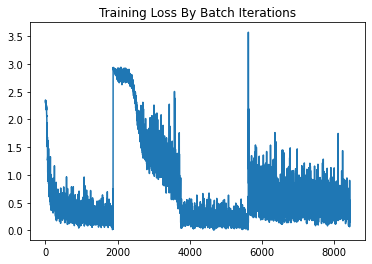

In [18]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Training Loss By Batch Iterations")

Text(0.5, 1.0, 'Loss By Epochs')

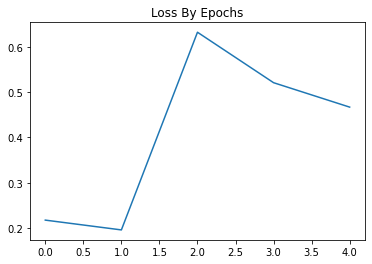

In [15]:
plt.plot(epoch_loss)
plt.title("Loss By Epochs")

Text(0.5, 1.0, 'Digit Recognition Accuracy By Epochs')

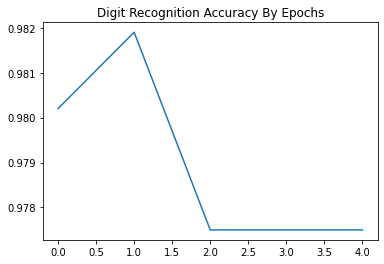

In [16]:
plt.plot(epoch_acc_dig)
plt.title("Digit Recognition Accuracy By Epochs")

Text(0.5, 1.0, 'Addition Accuracy By Epochs')

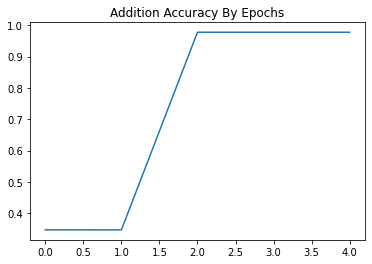

In [17]:
plt.plot(epoch_acc_sum)
plt.title("Addition Accuracy By Epochs")

## Final Prediction

In [19]:
a1, a2 = test(model, device, test_loader_mod)

Digit prediction loss: 711.615514755249 and Summation loss: 2174.740509033203
Digit prediction accuracy: 97.75 and Summation accuracy: 97.75


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
